In [13]:
import pandas as pd

df = pd.read_excel("preprocessed.xlsx")
columns_ignore = ['name', 'released', 'score', 'votes', 'gross', 'same_year']

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)

X = df.drop(
    columns_ignore,
    axis=1,
)
X = poly.fit_transform(X)
y = df["score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

In [40]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


def plot_predictions(y_test, y_pred):
    plt.scatter(y_test, y_pred, color="blue")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Predictions vs. Truth")
    plt.show()


def evaluate(model, X, y):
    pred = model.predict(X)
    print("Mean squared error: %.2f" % mean_squared_error(y, pred))
    print("Mean absolute error: %.2f" % mean_absolute_error(y, pred))
    print("Coefficient of determination: %.2f" % r2_score(y, pred))
    plot_predictions(y, pred)

## LinearRegression

In [16]:
from sklearn.linear_model import LinearRegression


linear_regressor = LinearRegression()
linear_regressor = linear_regressor.fit(X_train, y_train)

Mean squared error: 0.59
Coefficient of determination: 0.37


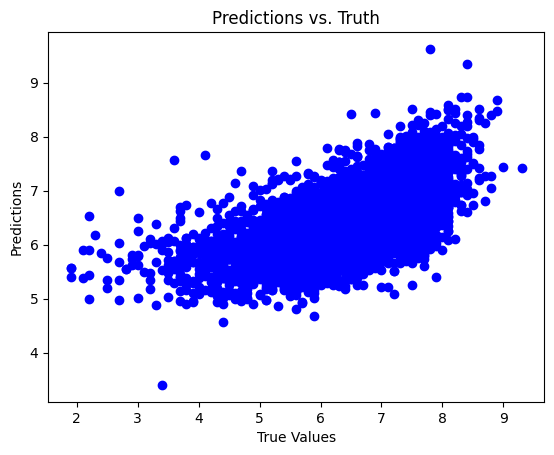

Mean squared error: 0.58
Coefficient of determination: 0.36


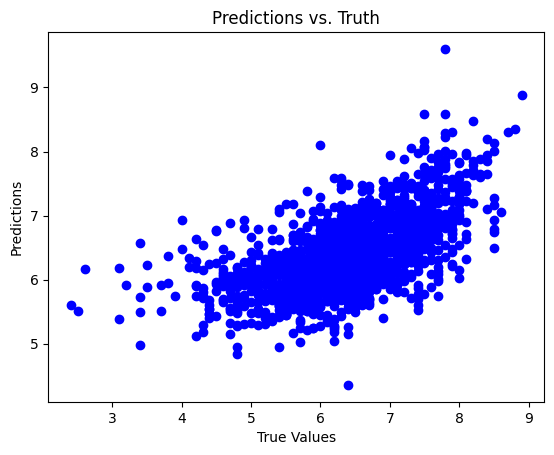

In [17]:
evaluate(linear_regressor, X_train, y_train)
evaluate(linear_regressor, X_test, y_test)

## DecisionTree

In [18]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=6)
decision_tree = decision_tree.fit(X_train, y_train)

Mean squared error: 0.63
Coefficient of determination: 0.32


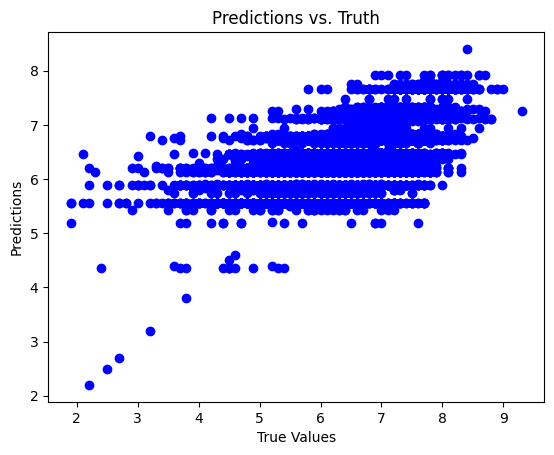

Mean squared error: 0.70
Coefficient of determination: 0.23


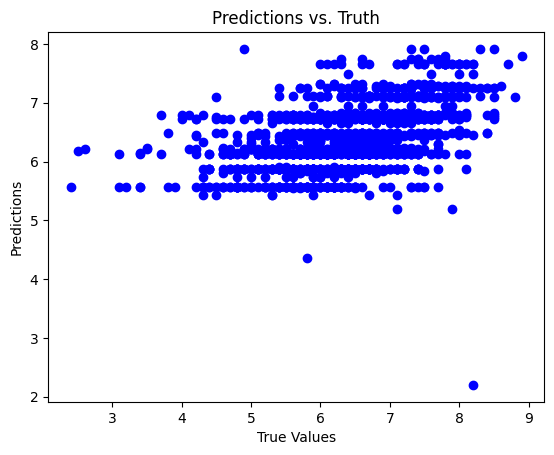

In [19]:
evaluate(decision_tree, X_train, y_train)
evaluate(decision_tree, X_test, y_test)

## Forest Regressor

In [20]:
# forest
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)

Mean squared error: 0.08
Coefficient of determination: 0.91


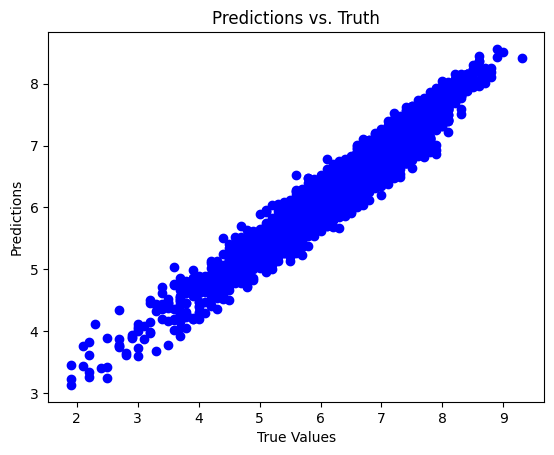

Mean squared error: 0.56
Coefficient of determination: 0.38


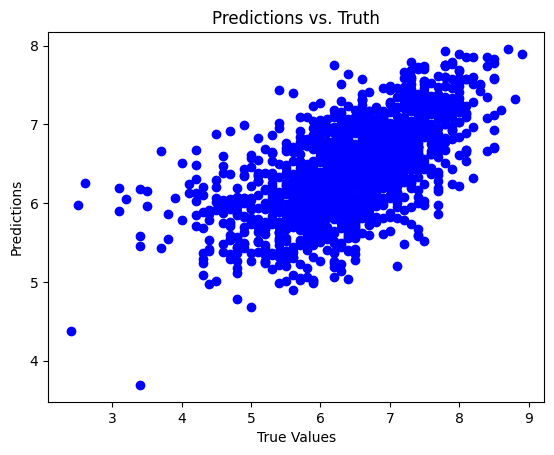

In [21]:
evaluate(forest, X_train, y_train)
evaluate(forest, X_test, y_test)

## Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor()
gradient_boosting = gradient_boosting.fit(X_train, y_train)

Mean squared error: 0.54
Coefficient of determination: 0.42


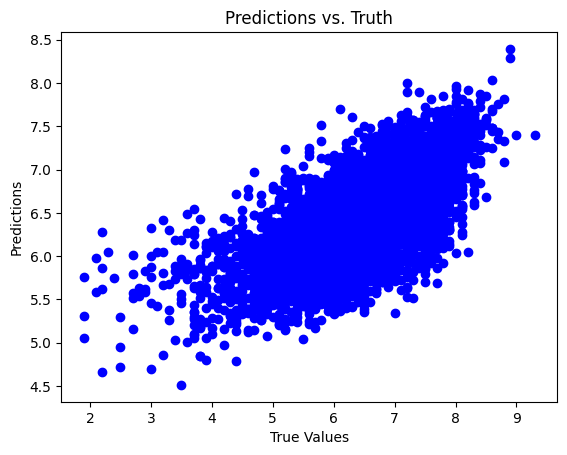

Mean squared error: 0.56
Coefficient of determination: 0.38


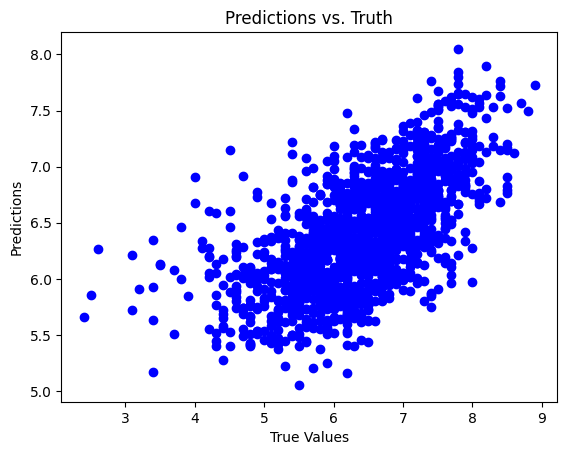

In [23]:
evaluate(gradient_boosting, X_train, y_train)
evaluate(gradient_boosting, X_test, y_test)

In [28]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=64, activation='logistic', solver='sgd', alpha=0, batch_size=1, learning_rate_init=.01, shuffle=True, momentum=0, n_iter_no_change=50, max_iter=250)
mlp = mlp.fit(X_train, y_train)

C:\Users\boomo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Mean squared error: 1.00
Coefficient of determination: -0.07


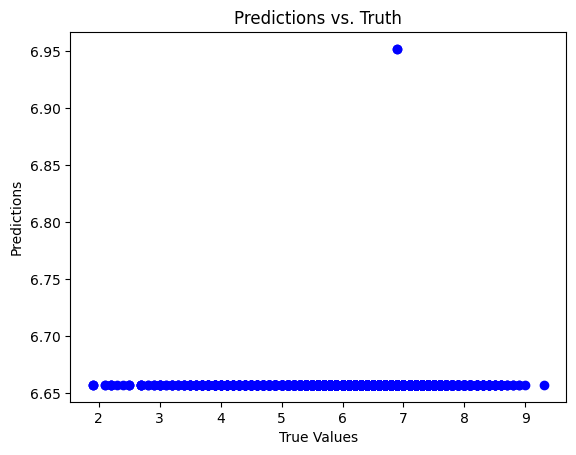

Mean squared error: 0.97
Coefficient of determination: -0.07


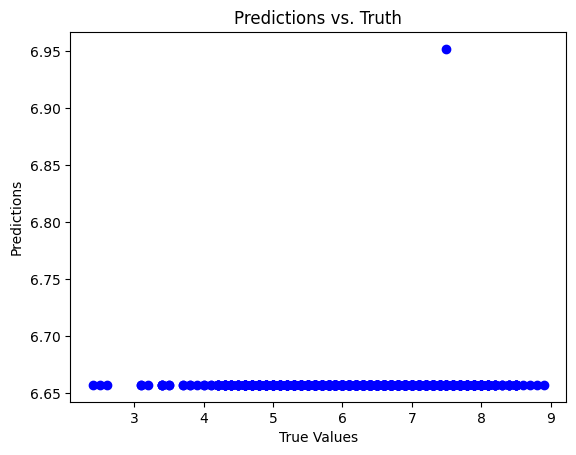

In [ ]:
evaluate(mlp, X_train, y_train)
evaluate(mlp, X_test, y_test)

## KNN

In [29]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)
knn = knn.fit(X_train, y_train)

Mean squared error: 0.69
Coefficient of determination: 0.26


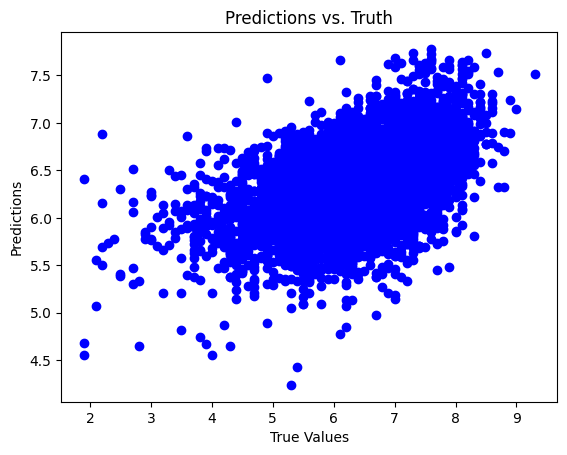

Mean squared error: 0.76
Coefficient of determination: 0.16


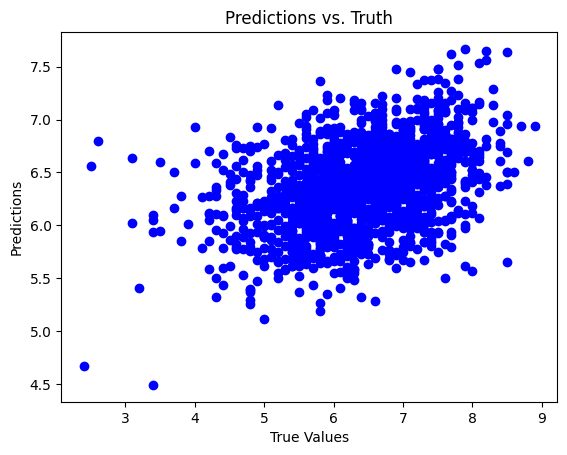

In [30]:
evaluate(knn, X_train, y_train)
evaluate(knn, X_test, y_test)

## Clustering

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans = kmeans.fit(X_train)

C:\Users\boomo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Mean squared error: 38.22
Coefficient of determination: -40.02


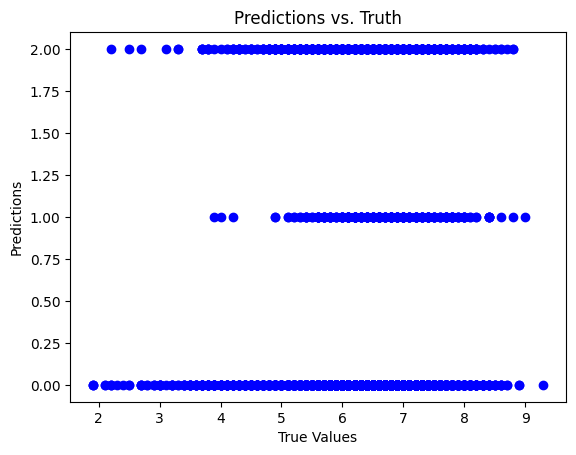

Mean squared error: 38.49
Coefficient of determination: -41.35


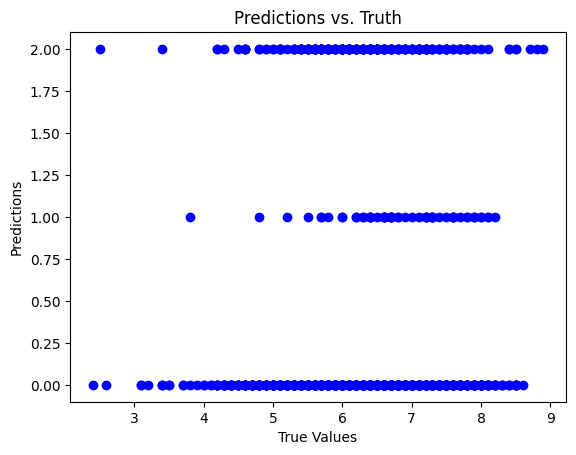

In [32]:
evaluate(kmeans, X_train, y_train)
evaluate(kmeans, X_test, y_test)

In [33]:
# Ensemble
from sklearn.ensemble import VotingRegressor

def weight(model):
    return 1/mean_squared_error(model.predict(X_test), y_test)

ereg = VotingRegressor(estimators=[('knn', knn), ('rf', forest), ('gb', gradient_boosting), ('lr', linear_regressor) #, ('mlp', mlp)
                                   ], weights=[weight(knn), weight(forest), weight(gradient_boosting), weight(linear_regressor)
                                               #, weight(mlp)
                                               ])
ereg = ereg.fit(X_train, y_train)

Mean squared error: 0.38
Mean absolute error: 0.47
Coefficient of determination: 0.59


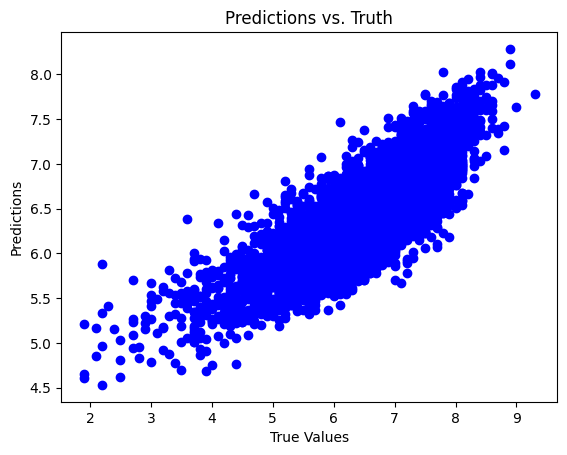

Mean squared error: 0.55
Mean absolute error: 0.57
Coefficient of determination: 0.39


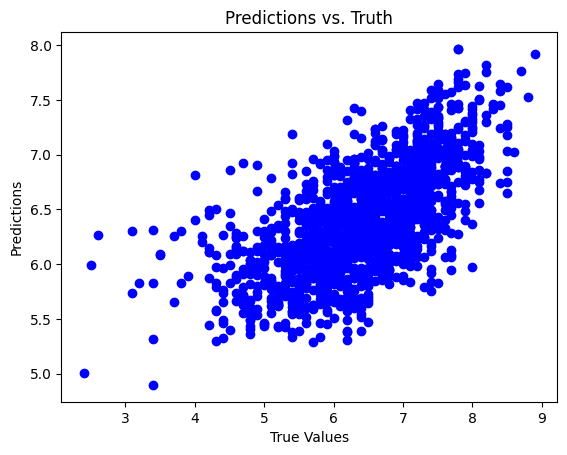

In [42]:
evaluate(ereg, X_train, y_train)
evaluate(ereg, X_test, y_test)

In [38]:
# Ensemble
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(estimators=[('knn', knn), ('rf', forest), ('gb', gradient_boosting), ('lr', linear_regressor), ('dt', decision_tree)], final_estimator=LinearRegression())
stack = stack.fit(X_train, y_train)

Mean squared error: 0.26
Mean absolute error: 0.38
Coefficient of determination: 0.72


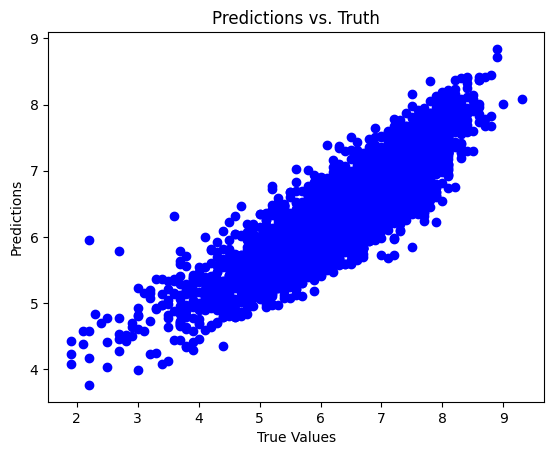

Mean squared error: 0.53
Mean absolute error: 0.56
Coefficient of determination: 0.42


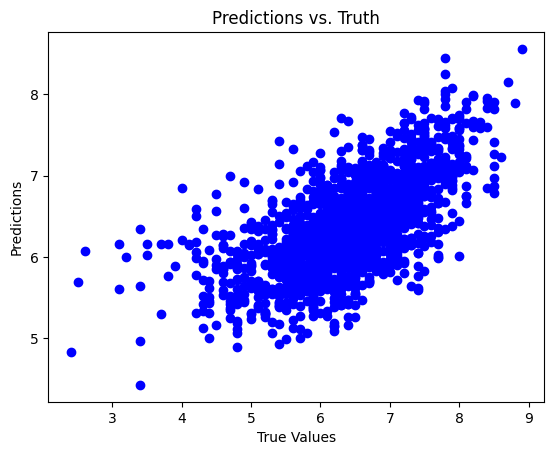

In [41]:
evaluate(stack, X_train, y_train)
evaluate(stack, X_test, y_test)